In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from  sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

In [3]:
df=pd.read_csv(r"D:\AI Eng\Projects\Smart Cart Clustering System\smartcart_customers.csv")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,172,88,88,3,8,10,4,7,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,2,1,6,2,1,1,2,5,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,111,21,42,1,8,2,10,4,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,10,3,5,2,2,0,4,6,0,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,46,27,15,5,5,3,6,5,0,0


In [4]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
Response                0
dtype: int64

## Data Preprocessing

### 1.Handeling Missing Values

In [5]:
df["Income"]=df["Income"].fillna(df["Income"].median())

### Fecture Engineering

In [6]:
#Adding Age Column
df["Age"]=2026-df["Year_Birth"] # by knowing age of customer we can understand spending

# the clustering algo can not handle well data datatype we have to convert into numerical value


In [7]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,88,88,3,8,10,4,7,0,1,69
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,1,6,2,1,1,2,5,0,0,72
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,21,42,1,8,2,10,4,0,0,61
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,3,5,2,2,0,4,6,0,0,42
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,27,15,5,5,3,6,5,0,0,45


In [8]:
# we are calculating Customer Platform join days
df["Dt_Customer"]=pd.to_datetime(df["Dt_Customer"],dayfirst=True)
referance=df["Dt_Customer"].max()
df["Customer_Ten_days"]=(referance-df["Dt_Customer"]).dt.days 

In [9]:
# Spending : we are combing the spending columns in to total_spend
spend_cols=['MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
df["Total_Spend"] = df[spend_cols].sum(axis=1)

In [10]:
# total Childern
df["total_childern"]=df["Kidhome"]+df["Teenhome"]

In [11]:
#Education
df["Education"].value_counts()
df["Education"]=df["Education"].replace(
    {
        "Basic":"Undergraduate","2n Cycle":"Undergraduate",
        "Graduation":"Graduate",
        "Master":"Postgraduate","PhD":"Postgraduate"
    }
)

In [12]:
#Marital_Status
df["Marital_Status"].value_counts()
df["Living_with"]=df["Marital_Status"].replace(
    {
        "Married":"Patner",
        "Together":"Patner",
        "Single":"Alone",
        "Divorced": "Alone",
    "Widow": "Alone",
    "Alone": "Alone",
    "Absurd": "Alone",
    "YOLO": "Alone"
    }
)


In [13]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Customer_Ten_days,Total_Spend,total_childern,Living_with
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,10,4,7,0,1,69,663,1649,0,Alone
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,1,2,5,0,0,72,113,38,2,Alone
2,4141,1965,Graduate,Together,71613.0,0,0,2013-08-21,26,426,...,2,10,4,0,0,61,312,801,0,Patner
3,6182,1984,Graduate,Together,26646.0,1,0,2014-02-10,26,11,...,0,4,6,0,0,42,139,67,1,Patner
4,5324,1981,Postgraduate,Married,58293.0,1,0,2014-01-19,94,173,...,3,6,5,0,0,45,161,446,1,Patner


In [14]:
df["Living_with"].value_counts()

Living_with
Patner    1444
Alone      796
Name: count, dtype: int64

## Drop Columns 

In [22]:
col=['ID', 'Year_Birth', 'Marital_Status', 'Kidhome',
       'Teenhome','Dt_Customer']
spending_purchase=['MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds']
drop_columns=col+spending_purchase
df_update=df.drop(columns=drop_columns)

In [23]:
df_update.shape

(2240, 15)

## Handel Outliers

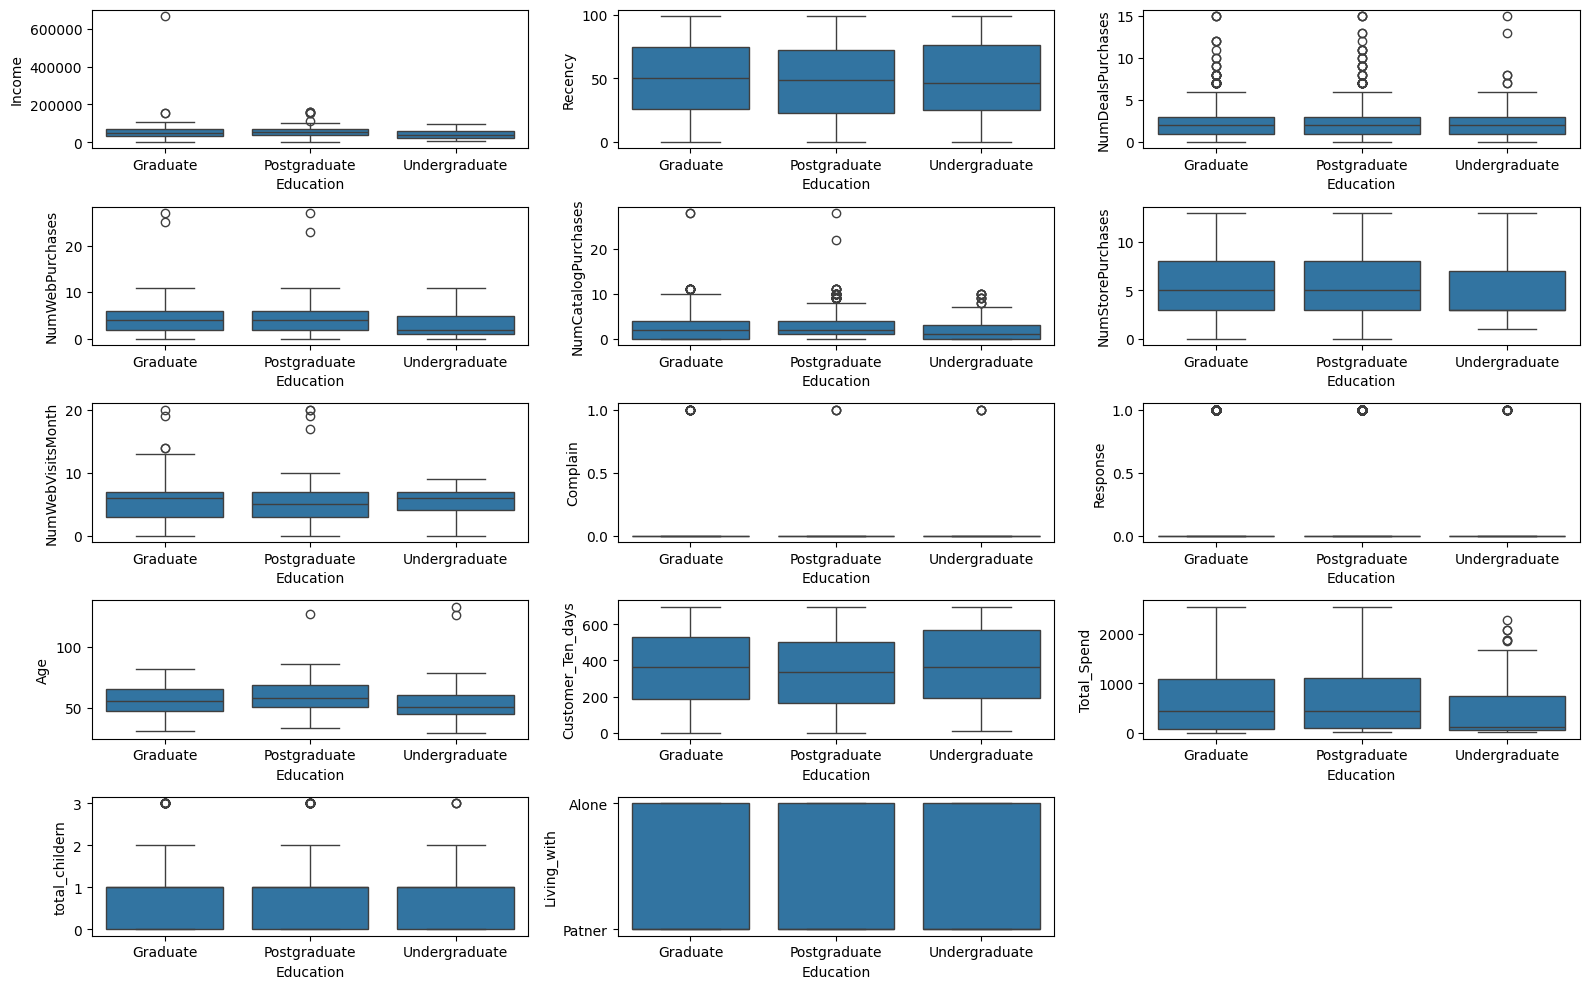

In [24]:
plt.figure(figsize=(16,10))

col = df_update.columns

for i in range(1, min(len(col), 16)):   
    plt.subplot(5,3,i)
    sns.boxplot(data=df_update, x="Education", y=col[i])

plt.tight_layout()
plt.show()

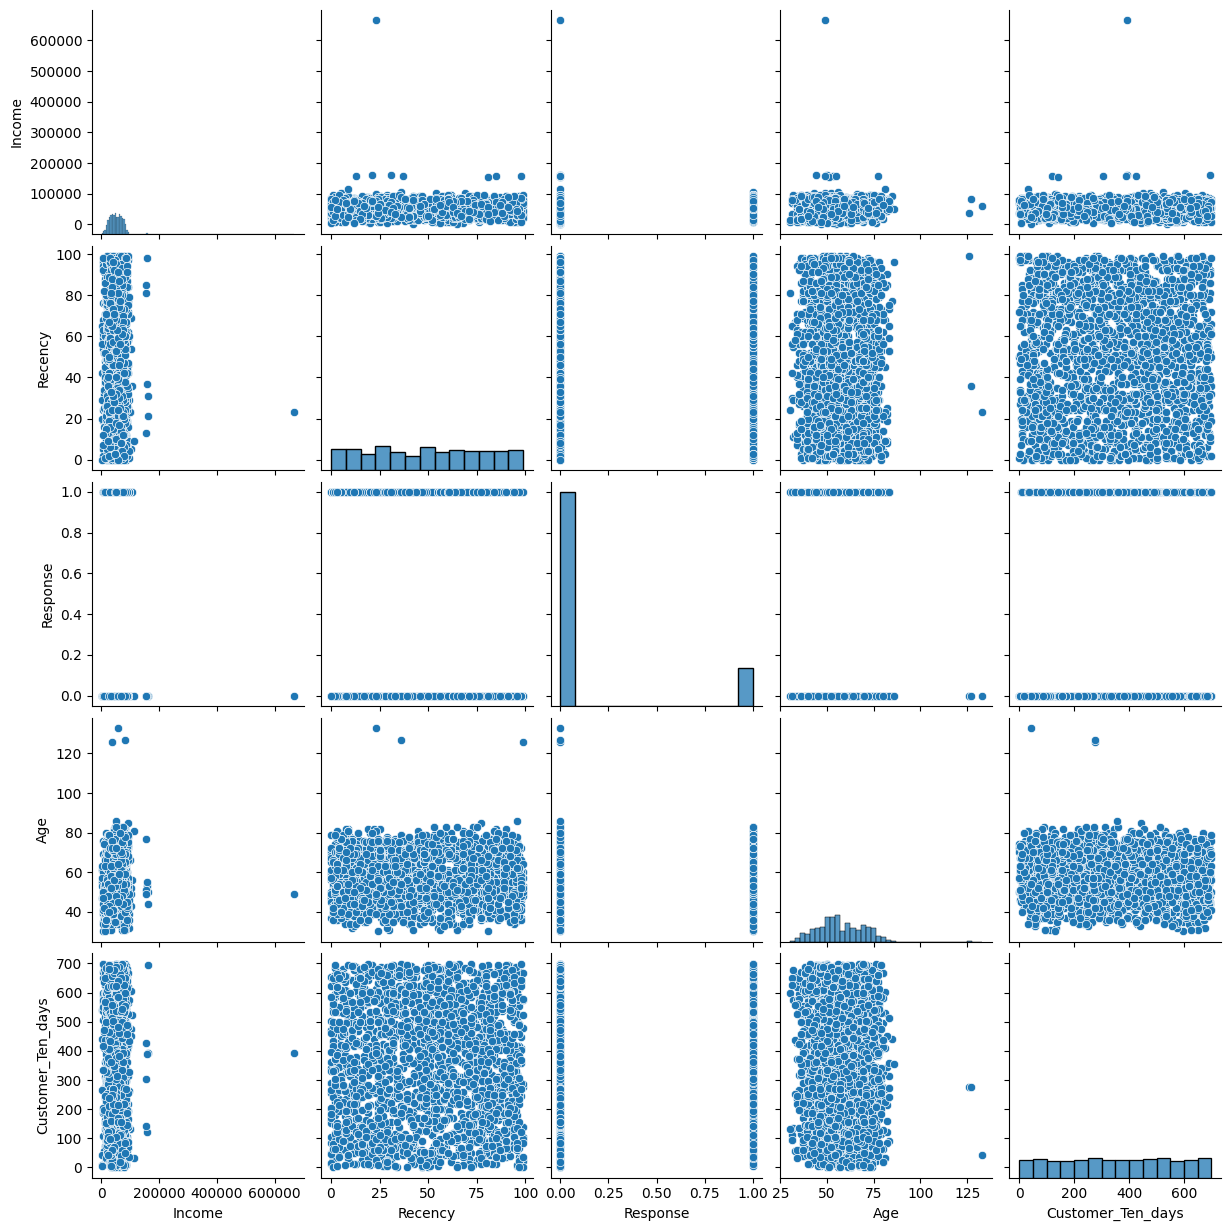

In [25]:
numerical_col=['Income', 'Recency','Response', 'Age', 'Customer_Ten_days']
#relative plot of some feactures 
sns.pairplot(df_update[numerical_col]) # this a best plot for outliers detections


In [26]:
#Remove outliers 
df_clean=df_update.copy()
print("Size of data with Outliers : ",len(df_clean))
df_clean=df_clean[(df_clean["Income"]<600000)]
df_clean=df_clean[(df_clean["Age"]<90)]
print("Size of data with out Outliers : ",len(df_clean))

Size of data with Outliers :  2240
Size of data with out Outliers :  2236


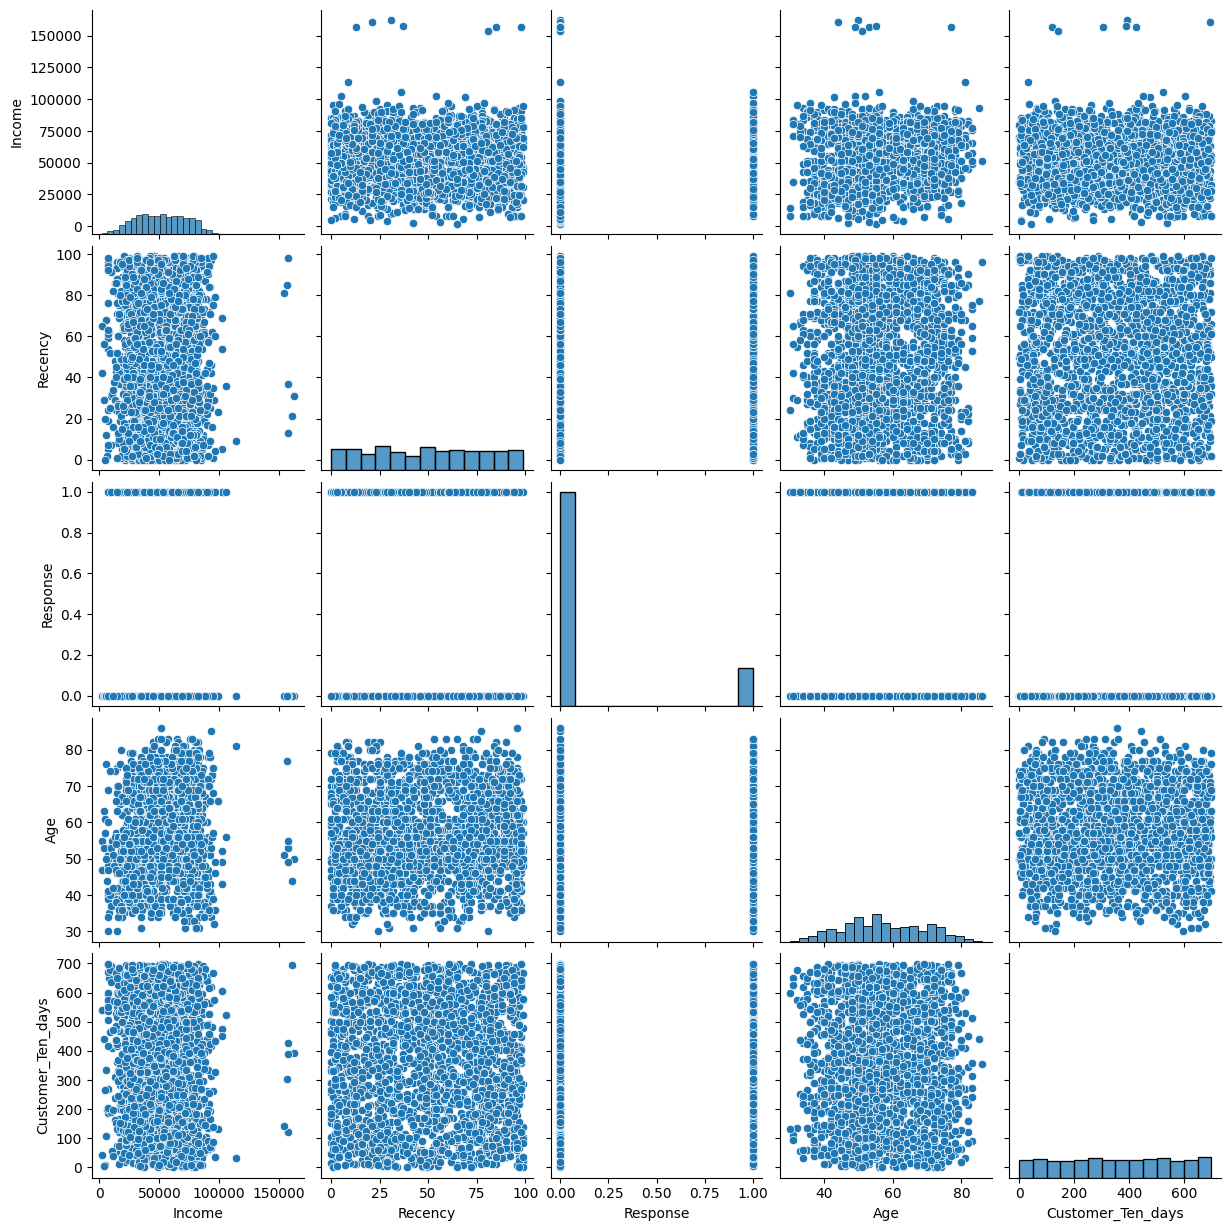

In [27]:
sns.pairplot(df_clean[numerical_col])

## Heatmap

In [31]:
co_relation=df_clean.corr(numeric_only=True)

<Axes: >

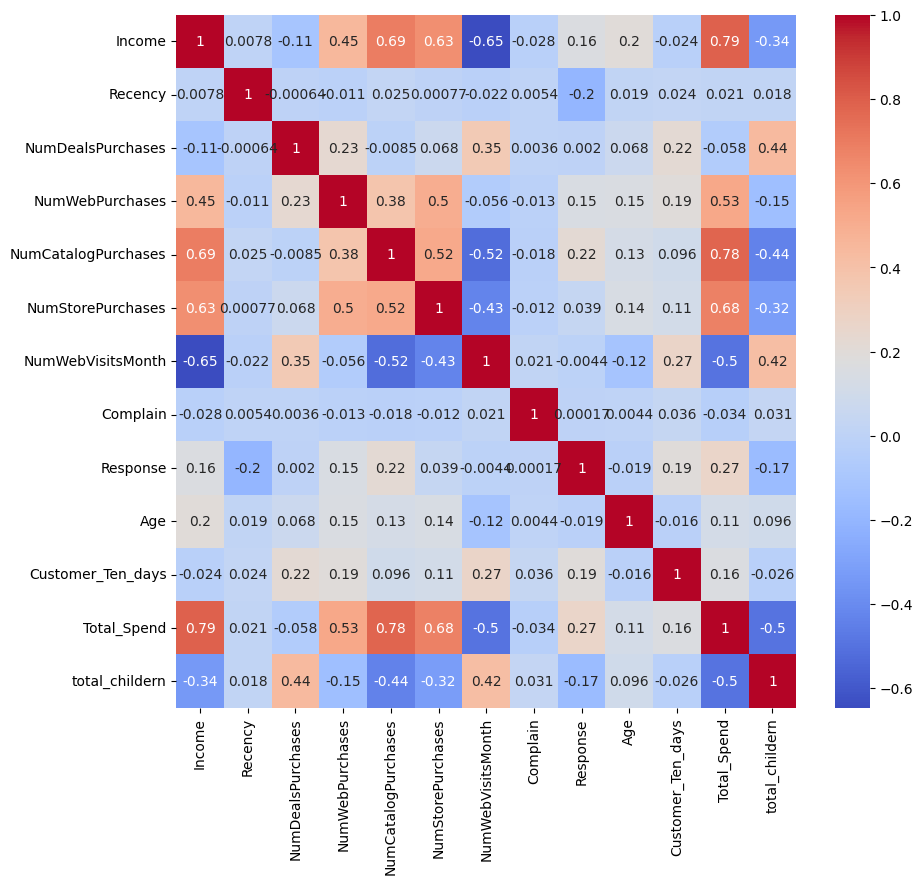

In [37]:
plt.figure(figsize=(10,9))
sns.heatmap(co_relation,annot=True,cmap="coolwarm")

In [ ]:
label=LabelEncoder()
df_update["Education"]=label.fit_transform(df_update["Education"])
df_update["Living_with"]=label.fit_transform(df_update["Living_with"])


In [ ]:
df_update.head()